In [3]:
import tensorflow as tf
#keras-3.0.5 & tensorflow-2.16.1 버전 확인 잘해야함. 안맞으면 작동 안함..
#pip install keras==3.0.5
from keras.src.legacy.preprocessing.image import ImageDataGenerator
tf.test.gpu_device_name()

''

In [4]:
import numpy as np
import pandas as pd
import cv2  
import os  
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imshow, subplots, show
%matplotlib inline

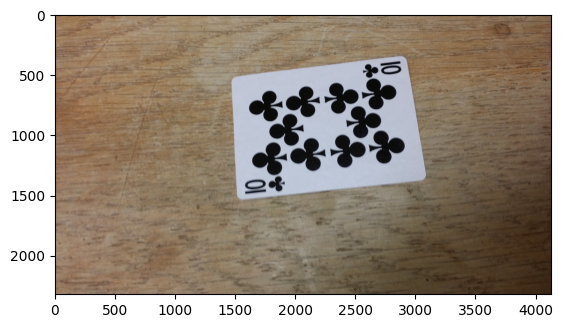

In [5]:
image = imread('C:/Users/syoun/repos/detection/playing-cards/img/cards-[C0]-001.jpg')
images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
imshow(images[0])
show()

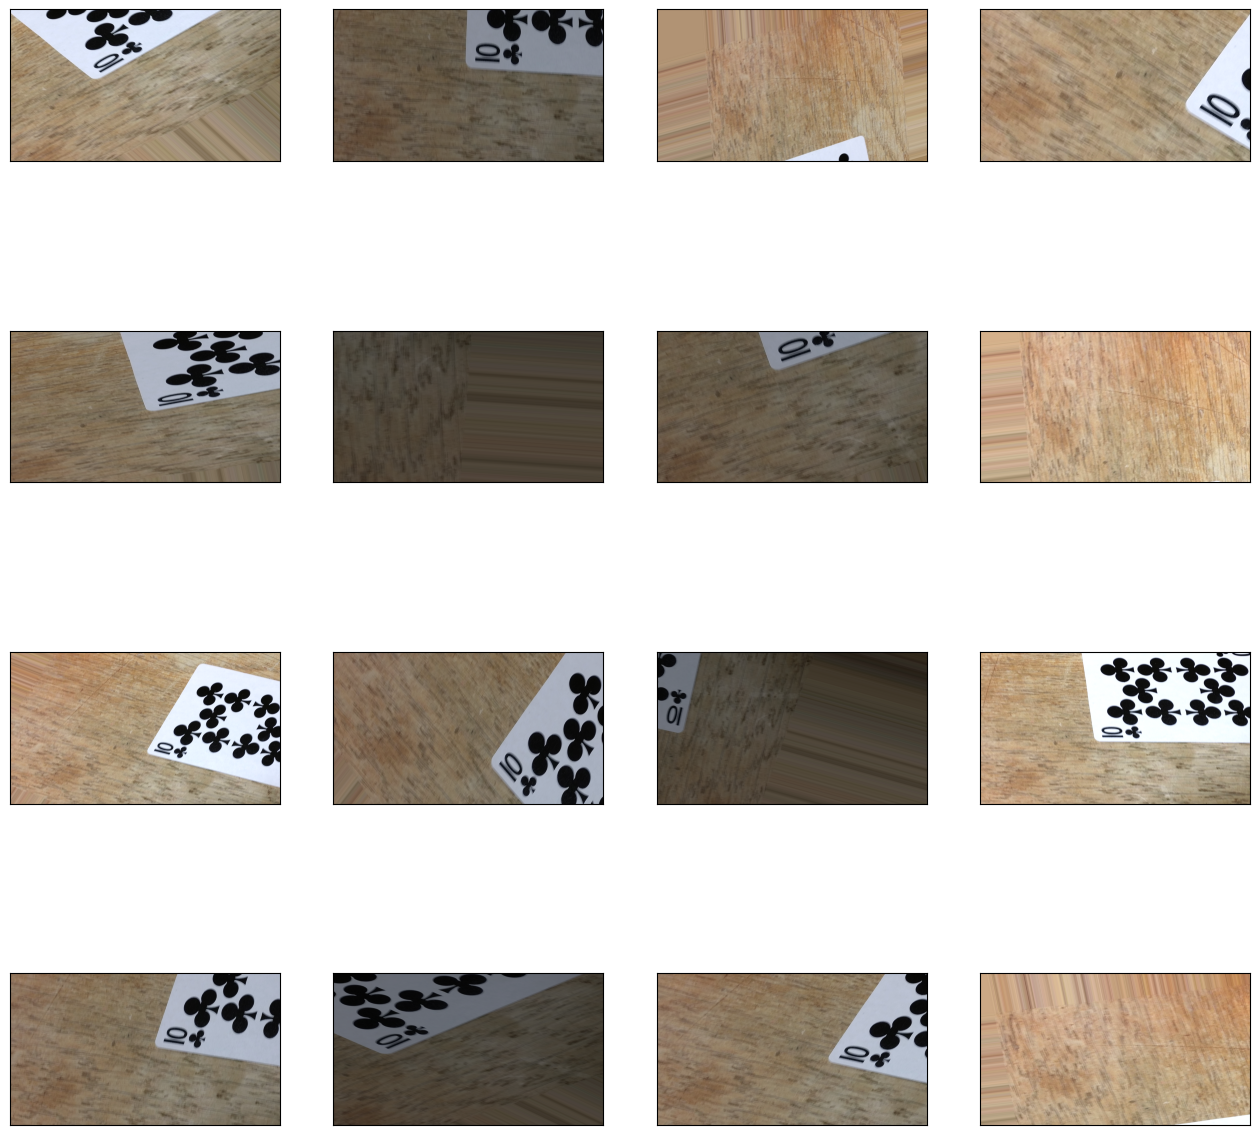

In [9]:
data_generator = ImageDataGenerator(rotation_range=90, brightness_range=(0.5, 1.5), shear_range=15.0, zoom_range=[.3, .8])
data_generator.fit(images)
image_iterator = data_generator.flow(images)

plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(next(image_iterator)[0].astype('int'))
plt.show()

In [12]:
	
data=[]

for i, img in tqdm(enumerate(os.listdir('C:/Users/syoun/repos/detection/playing-cards/img/'))):
    label=i
    
    img = cv2.imread('C:/Users/syoun/repos/detection/playing-cards/img/'+img, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (180, 180))
    imgs = img.reshape((1, img.shape[0], img.shape[1], 1))
    data_generator = ImageDataGenerator(rotation_range=90, brightness_range=(0.5, 1.5), shear_range=15.0, zoom_range=[.3, .8])
    data_generator.fit(imgs)
    image_iterator = data_generator.flow(imgs)
    
    for x in range(750):
        img_transformed=next(image_iterator)[0].astype('int') / 255
        data.append([img_transformed, label])

shuffle(data)

177it [05:50,  2.24s/it]

In [ ]:
np.save('C:/Users/syoun/repos/detection/data.npy', data)

In [ ]:
data = np.load('C:/Users/syoun/repos/detection/data.npy', allow_pickle=True)

In [ ]:
train=data[:37000]
test=data[37000:]

In [ ]:
train_X=[]
train_y=[]
for x in train:
    train_X.append(x[0]) 
    train_y.append(x[1])
    
test_X=[]
test_y=[]
for x in test:
    test_X.append(x[0]) 
    test_y.append(x[1])

In [ ]:
train_X=np.array(train_X)
train_y=np.array(train_y)

test_X=np.array(test_X)
test_y=np.array(test_y)

In [ ]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

epochs=250
batch_size=32

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(train_X.shape[1], train_X.shape[2], train_X.shape[3])),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(52, activation='softmax')
])

model.summary()

cp = tf.keras.callbacks.ModelCheckpoint(filepath="250epochs_conv.h5",
                               save_best_only=True,
                               verbose=0)

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, 
                    validation_data=(test_X, test_y), callbacks=[cp]).history

In [ ]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(acc))

plt.figure(figsize = (12,8))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.figure(figsize = (12,8))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
df=pd.read_csv('card_labels.csv')
labels=list(df['label'])

predictions=model.predict_classes(test_X)

sample=test_X[:16]

plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample[i].reshape(sample.shape[1], sample.shape[2]))
    plt.xlabel(labels[predictions[i]])
plt.show()